In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl



%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle
import bobsegutils as bsu

from skimage.draw import circle

import csv

from skimage import io

import math

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  
    """
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

### Reads noisy image, denoised image and the corresponding csv file for tracklets to serve as GT

In [3]:
noisy_image_filename = '/Users/prakash/Downloads/MAX_20180523_LP823_hmr-1_sax-7_RNAi_02-01/MAX_20180523_LP823_hmr-1_sax-7_RNAi_02-01_Myo_denoised.tif'
denoised_image_file_name = '/Users/prakash/Downloads/MAX_20180523_LP823_hmr-1_sax-7_RNAi_02-01/MAX_20180523_LP823_hmr-1_sax-7_RNAi_02-01_Myosin_denoised.tif'
csv_path = '/Users/prakash/Downloads/MAX_20180523_LP823_hmr-1_sax-7_RNAi_02-01/MAX_20180523_LP823_hmr-1_sax-7_RNAi_02-01_tracklets.csv'
noisy_image = imread(noisy_image_filename)
denoised_image = imread(denoised_image_file_name)
print('Shape of stack:', noisy_image.shape, denoised_image.shape)

Shape of stack: (26, 750, 430, 1) (24, 750, 430)


### Extract flow vectors from tracklets in csv file

In [4]:
### Read the results csv file, delete all entries which are not coordinates and write it as a new csv file
puncta = []
edges = []
with open(csv_path,"r") as source:
    rdr= csv.reader( source )
    next(rdr)
    for line in source:
        if(line.startswith("edgep1,edgep2") ):
            break
        else:
            puncta.append(line[:-1])

edgeCount = False            
with open(csv_path,"r") as source:
    rdr= csv.reader( source )
    next(rdr)
    for line in source:
        if(line.startswith("edgep1,edgep2") ):
            edgeCount = True
        if(edgeCount):
            edges.append(line[:-1])
        

In [5]:
modified_edges = []
modified_puncta = []
for edge in range(1, len(edges)):
    modified_edges.append([float(edge) for edge in edges[edge].split(',')])
for punctum in range(len(puncta)):
    modified_puncta.append([float(punctum) for punctum in puncta[punctum].split(',')])

In [6]:
flow_vectors_gt = []
for edge in modified_edges:
    id1 = edge[0]
    id2 = edge[1]
    puncta1 = modified_puncta[int(id1)]
    puncta2 = modified_puncta[int(id2)]
    time_diff = np.abs(puncta1[-1] - puncta2[-1])
    if(puncta1[-1]<puncta2[-1] and time_diff ==1):
        time = int(puncta1[-1])
        x = puncta1[1]
        y = puncta1[2]
        u = puncta2[1] - puncta1[1]
        v = puncta2[2] - puncta1[2]
        
    elif(puncta2[-1]<puncta1[-1] and time_diff ==1):
        time = int(puncta2[-1])
        x = puncta2[1]
        y = puncta2[2]
        u = puncta1[1] - puncta2[1]
        v = puncta1[2] - puncta2[2]
    elif(puncta2[-1]==puncta1[-1]):
        continue
    flow_vectors_gt.append((x,y,u,v,time))

In [7]:
if len(set(flow_vectors_gt)) == len(flow_vectors_gt):
    print("no duplicates found!")

no duplicates found!


# Comparison of automated GUI flow beofre denoising vs after denoising

### Load flow images obtained from GUI for both denoised and noisy images

In [8]:
flow = imread("/Users/prakash/Downloads/MAX_20180523_LP823_hmr-1_sax-7_RNAi_02-01/MAX_20180523_LP823_hmr-1_sax-7_RNAi_02-01_noisyFlow.tif")
# noisy_flow = imread("/Users/prakash/Downloads/MAX_2018001_LP823_Control-02-02-2/")

#### Extract GT flow vectors and computed flow vectors

In [9]:
flow_vectors_computed = []
for vec in range(len(flow_vectors_gt)):
    int_x = round(flow_vectors_gt[vec][0])
    int_y = round(flow_vectors_gt[vec][1])
    time = flow_vectors_gt[vec][4]
    computed_u = flow[time][int_y][int_x]
    computed_v = flow[time+1][int_y][int_x]
    flow_vectors_computed.append((int_x, int_y, computed_u, computed_v, time))

In [10]:
final_coordinates_gt = []
final_coordinates_computed = []
initial_coordinates = []
for i in range(len(flow_vectors_gt)):
    
    final_coordinates_gt.append((flow_vectors_gt[i][0]+flow_vectors_gt[i][2], flow_vectors_gt[i][1]+flow_vectors_gt[i][3]))
    final_coordinates_computed.append((flow_vectors_computed[i][0]+flow_vectors_computed[i][2], flow_vectors_computed[i][1]+flow_vectors_computed[i][3]))
    initial_coordinates.append((flow_vectors_gt[i][0],flow_vectors_gt[i][1]))

#### Compute relative distance lag and relative angular lag

In [11]:
angle_lag = []
relative_angle_lag = []
for i in range(len(flow_vectors_gt)):
    angle = angle_between(final_coordinates_gt[i], final_coordinates_computed[i])*180/math.pi
    angle_lag.append(angle)
    relative_angle_lag.append(angle/(angle_between(final_coordinates_gt[i], initial_coordinates[i])*180/math.pi))

In [12]:
distance_lag = []
relative_distance_lag = []
for i in range(len(flow_vectors_gt)):
    p1 = final_coordinates_gt[i]
    p2 = final_coordinates_computed[i]
    p3 = initial_coordinates[i]
    distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )
    distance_lag.append(distance)
    relative_distance_lag.append(distance/(math.sqrt( ((p1[0]-p3[0])**2)+((p1[1]-p3[1])**2) )+1e-50))

In [13]:
np.median(np.array(distance_lag))

3.6806454776960464

#### Plotting

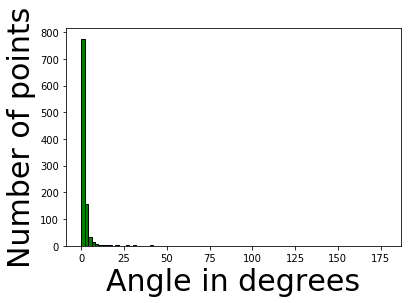

<Figure size 3600x3600 with 0 Axes>

In [14]:
plt.hist(relative_angle_lag, bins=range(0,180,2),histtype='bar', color='green', ec='black')
plt.xlabel('Angle in degrees',fontsize=30)
plt.ylabel('Number of points',fontsize=30)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.figure(figsize=(50,50))
plt.show()

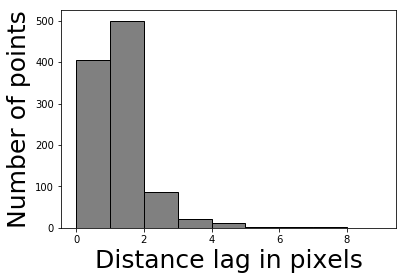

In [15]:
plt.hist(relative_distance_lag, bins=range(0,10,1), histtype='bar', color='gray', ec='black')
plt.xlabel('Distance lag in pixels',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

In [16]:
print("Relative angular lag:", np.median(np.array(relative_distance_lag)))
print("Relative distance lag:", np.median(np.array(relative_angle_lag)))

Relative angular lag: 1.1520344385885422
Relative distance lag: 1.1810752886881537
